# Part 2: Variational Methods - Denoising Problems

## Setup and Helper Functions

In [1]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
def compute_errors(original, images):
    errors = [np.abs(original - image).mean() for image in images]
    relative_errors = [(error / errors[0]) for error in errors]
    return relative_errors

In [3]:
def display_images(images, titles, rows, cols):
    num_images = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(rows):
        for j in range(cols):
            if i * cols + j < num_images:
                axes[i, j].imshow(images[i * cols + j], cmap='gray')
                axes[i, j].set_title(titles[i * cols + j])
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
# Import image
I_orig_img = Image.open('lotr.jpg')
I_orig_img = I_orig_img.convert('L')
I_orig = np.array(I_orig_img)/255.0
h, w = np.shape(I_orig)

# Add noise
gauss = np.random.normal(0, 0.22, (h, w))
gauss = gauss.reshape(h, w)
I_n = I_orig + gauss

# Visualize original image
# I_orig_img.show()

In [5]:
# Display params
disp_rows = 4
disp_cols = 4

n_steps = (disp_cols * disp_rows) # Number of repetitions (set by display size, includes starting image)
conv_per_step = 2 # Number of convolutions per step

## Task 1: Gaussian

In [6]:
def gaussian_filter(size, sigma):
    # Create the 1D Gaussian kernel
    kernel = np.fromfunction(
        #lambda x: (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(x - size // 2) ** 2 / (2 * sigma ** 2)),
        lambda x: np.exp(-(x - size // 2) ** 2 / (2 * sigma ** 2)),
        (size,),
        dtype=np.float64
    )
    # Normalize
    kernel /= np.sum(kernel)
    # Convert 1D kernel to 2D by outer product
    kernel = np.outer(kernel, kernel)
    return kernel

def apply_gaussian_filter(image, size, sigma, conv_per_step, n_steps):
    kernel = gaussian_filter(size, sigma)
    convolved_images = []
    for _ in range(n_steps):
        for _ in range(conv_per_step):
            image = convolve2d(image, kernel, mode='same', boundary='symm')
        convolved_images.append(image)
    return convolved_images

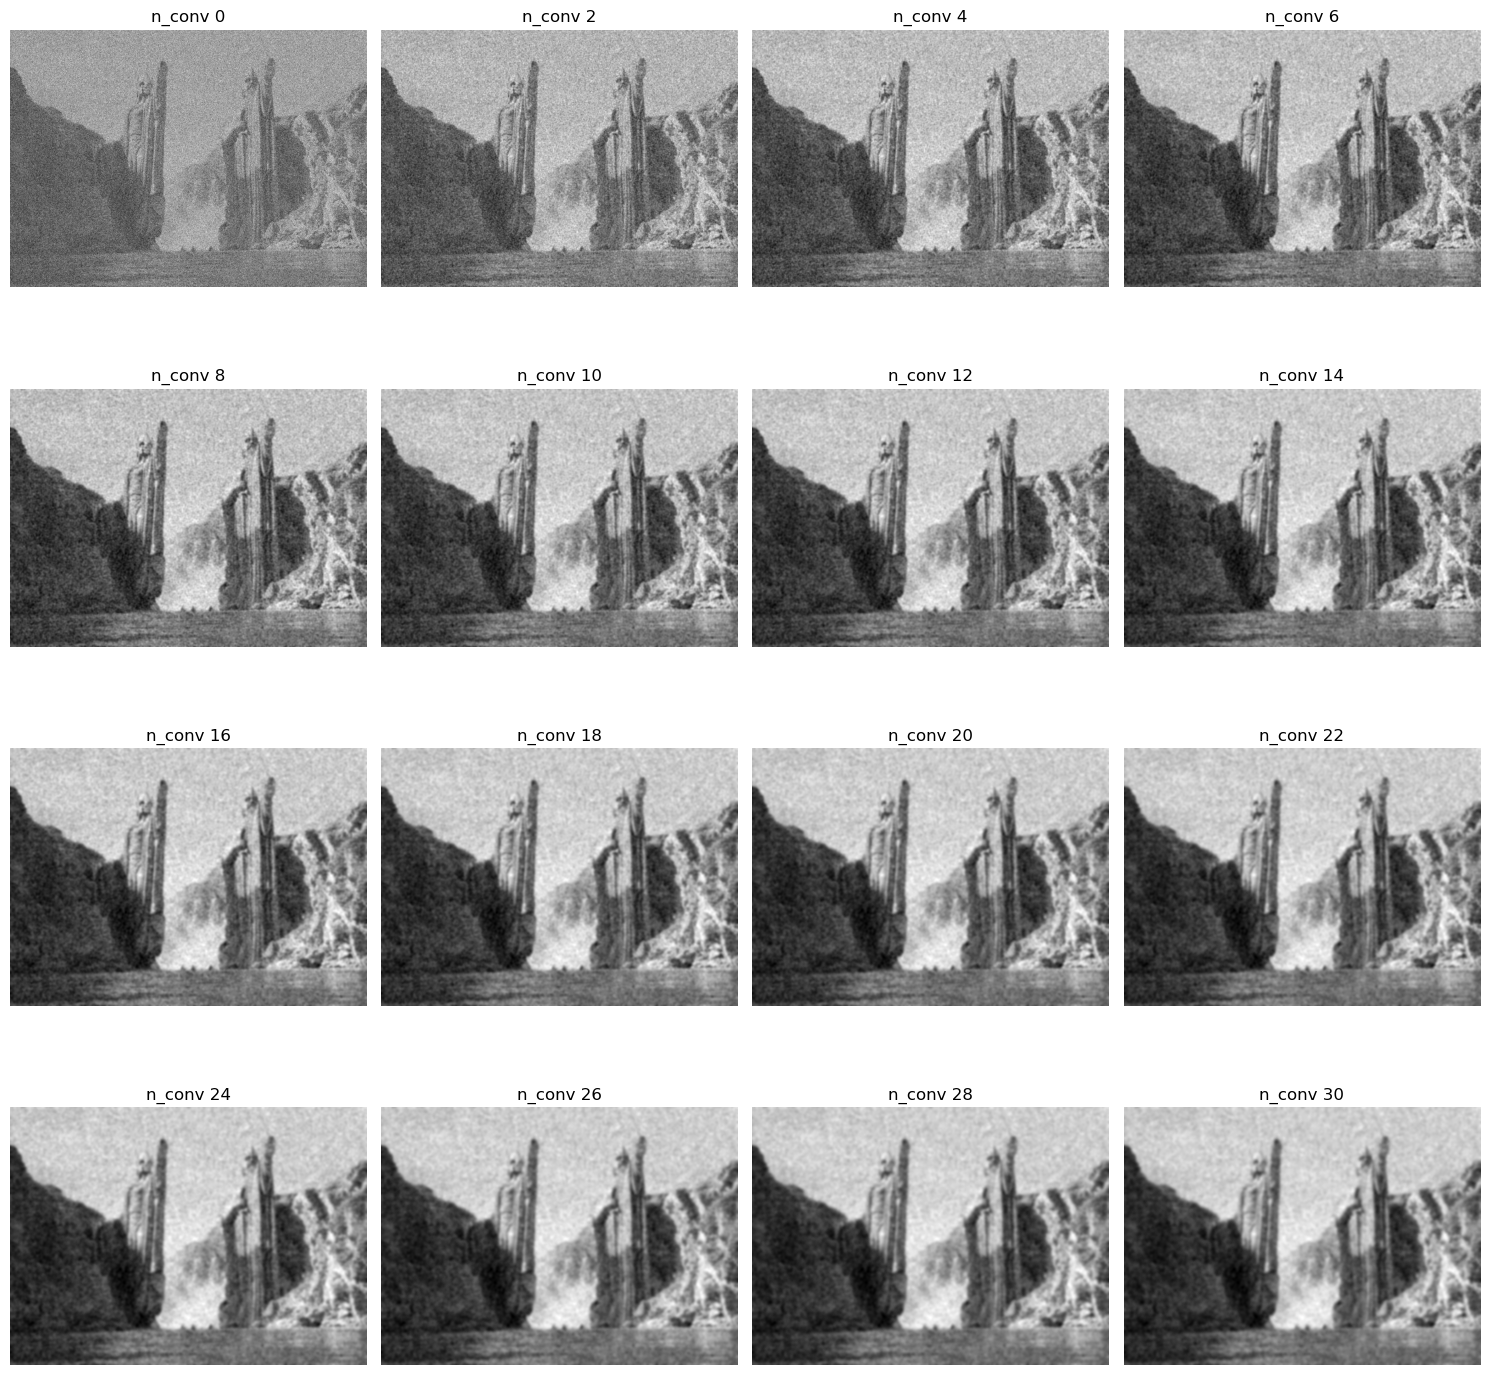

In [30]:
# Gaussian filter convolution parameters
size = 5  # Filter size
sigma = 0.5  # Sigma value

gauss_convolved_images = apply_gaussian_filter(I_n, size, sigma, conv_per_step, n_steps-1)
gauss_convolved_images.insert(0, I_n)

# Set titles
titles = [("n_conv " + str(conv_per_step*i)) for i in range(n_steps)]

# Display convolved images
display_images(gauss_convolved_images, titles, disp_rows, disp_cols)

#Image.fromarray((np.clip(gauss_convolved_images[15]*255.0, 0, 255)).astype(np.uint8)).show()

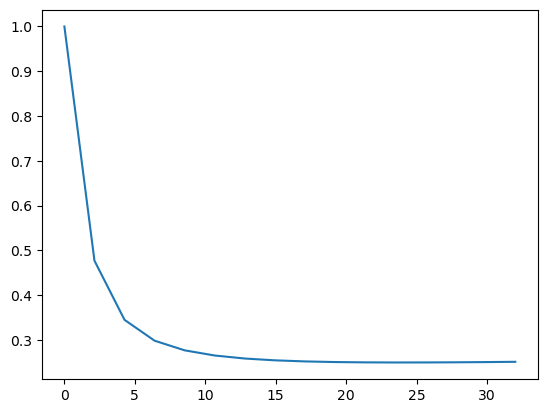

In [8]:
# Error visualization
x_axis1 = np.linspace(0, conv_per_step * n_steps, n_steps)
errors1 = compute_errors(I_orig, gauss_convolved_images)

plt.plot(x_axis1, errors1)
plt.show()

## Task 2: Heat Diffusion

In [26]:
def apply_heat_filter(image, conv_per_step, n_steps):
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    convolved_images = []
    old_image = np.copy(image)
    for _ in range(n_steps):
        for _ in range(conv_per_step):
            laplacian_2d = convolve2d(old_image, kernel, mode='same', boundary='symm')
            laplacian_2d -= 4 * old_image
            new_image = laplacian_2d * 0.1 + old_image
            old_image = new_image
        convolved_images.append(new_image)
    return convolved_images

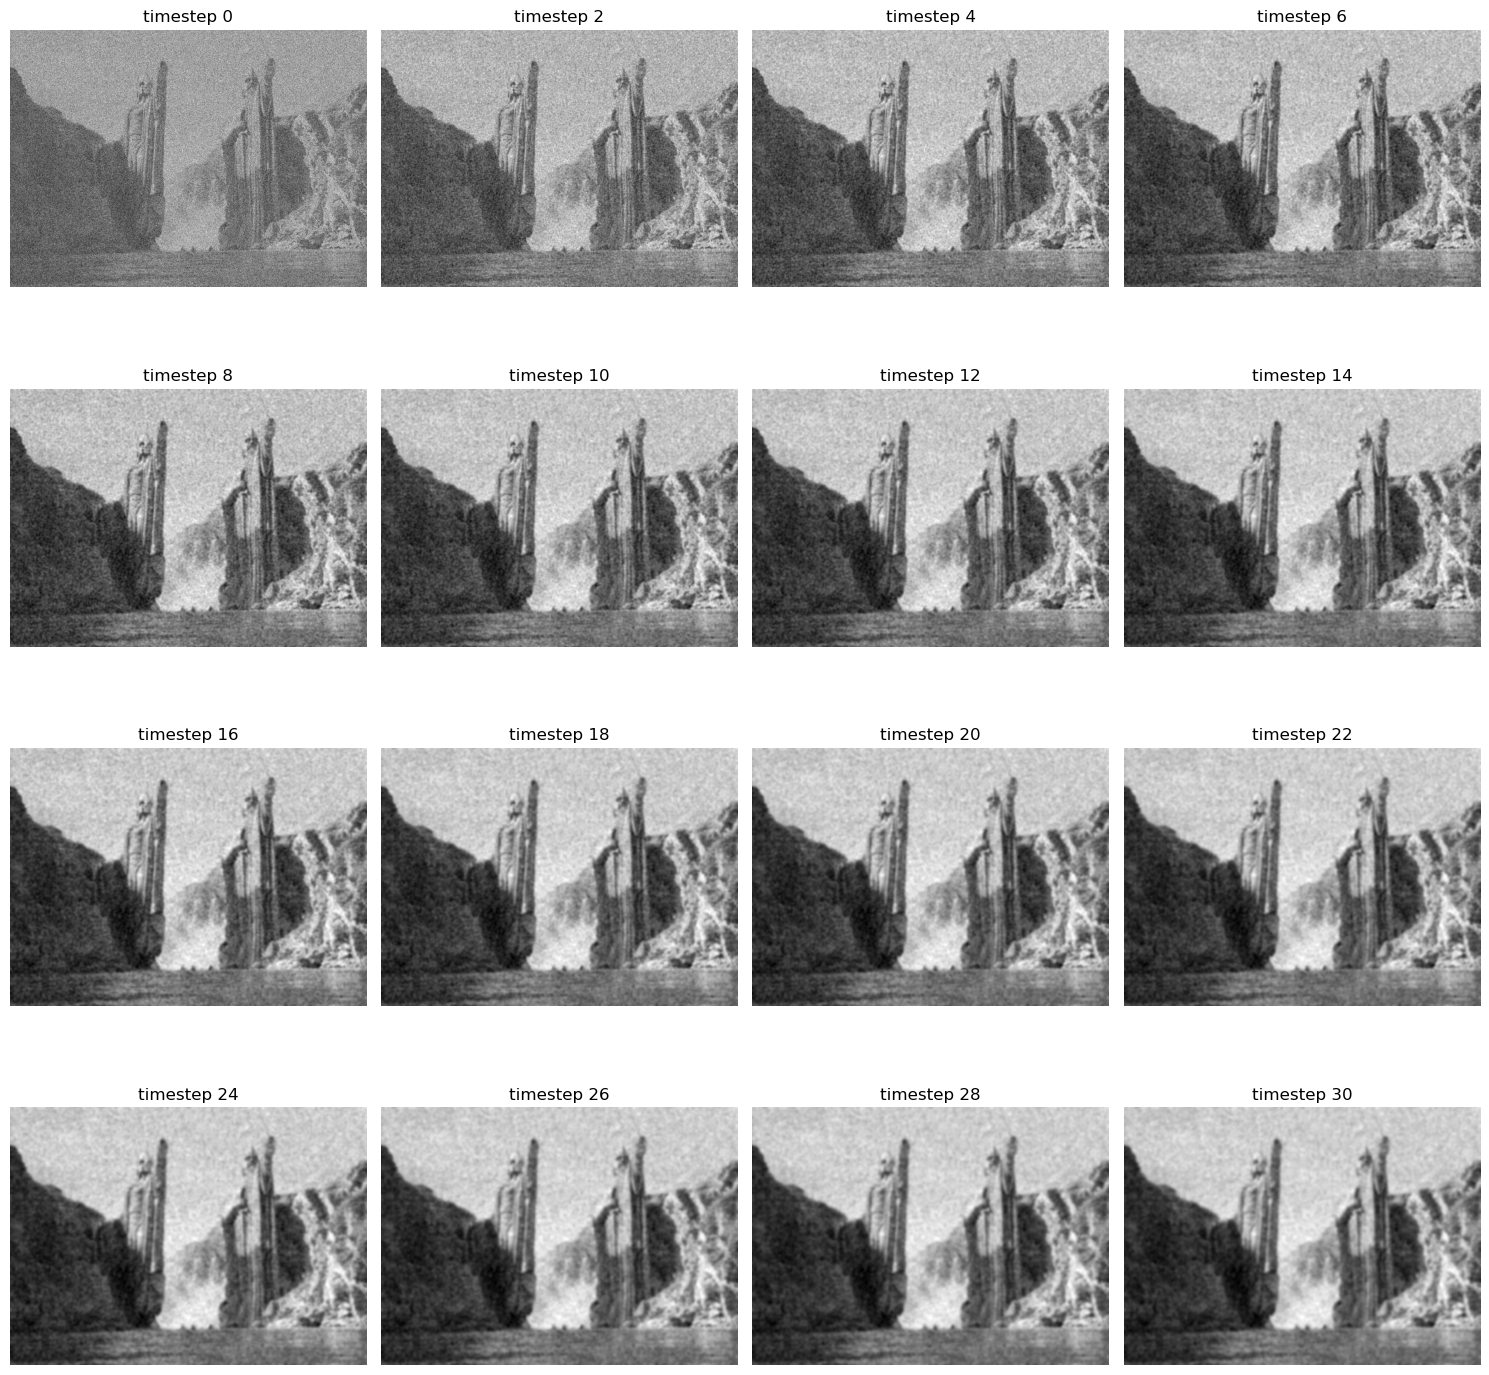

In [32]:
heat_convolved_images = apply_heat_filter(I_n, conv_per_step, n_steps-1)
heat_convolved_images.insert(0, I_n)

# Set titles
titles = [("timestep " + str(conv_per_step*i)) for i in range(n_steps)]

# Display convolved images
display_images(heat_convolved_images, titles, disp_rows, disp_cols)

#Image.fromarray((np.clip(gauss_convolved_images[15]*255.0, 0, 255)).astype(np.uint8)).show()

# Errors

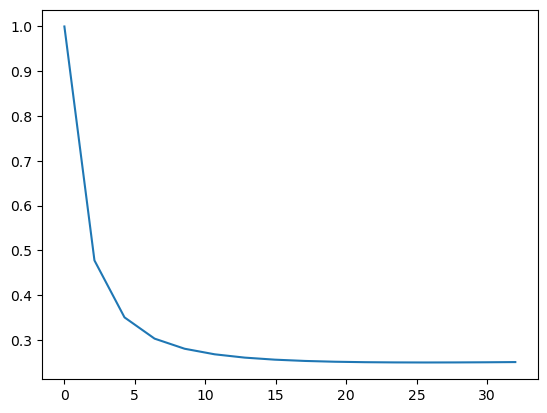

In [28]:
# Error visualization
x_axis2 = np.linspace(0, conv_per_step * n_steps, n_steps)
errors2 = compute_errors(I_orig, heat_convolved_images)

plt.plot(x_axis1, errors2)
plt.show()

## Task 3: Variational Approach

In [ ]:
# Empty

## Task 4: Comparison / Questions

Q1: Gaussian convolution does not converge, it strays away from a correct result after a certain number of iterations and the results get worse.

Q2: Heat diffusion converges in infinity. The converged results also depends on the boundary conditions since applying convolution with Dirichlet boundary conditions, the missing values outside the boundaries are assumed to be zeros or any other fixed value specified by the user. This means that the convolution operation considers the boundaries as if they were extended with zeros or the fixed value. Conversely when applying convolution with Neumann boundary conditions, the missing values outside the boundaries are estimated by mirroring the values at the boundary. This means that the convolution operation considers the boundaries as if they were reflected copies of the actual boundary values. In this example using Neumann boundary conditions the error converges approximately to 0.3.

Q3: In the context of image denoising, the Euler-Lagrange equation is used to derive an optimization problem that minimizes an energy functional. The energy functional is defined based on a mathematical model that represents the trade-off between preserving image details and reducing noise. In our case this is the equation (4) from the exercise sheet.

Q4: Euler-Lagrange solutions are not guaranteed to be globally optimal, they are only guaranteed to be locally optimal. To change the level of smoothing we can change the regularization parameter. A higher value of the regularization parameter will result in a smoother image, since the regularization term becomes more weighted in the energy functional.

Q5: Gaussian and heat diffusion seem to give similar results, and from a subjective viewpoint heat diffusion seems to keep the contrast of the image similar to the original (not-noisy) image. The variational approach produces better results since it tends to keep sharper edges and fine details while reducing noise.

Q6: The gaussian is simple to implement, yet it simply reduces high-frequency details. The heat diffusion method is also simple to implement, it can handle more types of noise (non-gaussian), but it is sensitive to the chosen time step parameter and causes loss of details similar to gaussian. Finally TV based approach can preserve edges and details while denoising the image but requires a more expensive calculation and fine-tuning of a regularization term.

Q7: The motivation for the three methods are as follows: Gaussian denoising is based on the assumption that the noise present on the image follows gaussian distribution. The convolved kernel acts like a low-pass filter on the image, preserving low-frequency components. Heat diffusion is based on the concept of heat induction, where heat spreads across a medium. In the context of image denoising, the method applies the diffusion equation to on the image, reducing noise. The laplacian operator (which measures the second derivative of the image) facilitates the smoothness. Finally TV aims to balance noise reduction and preservation of important image features such as edges and details. This is achieved by formulating denoising as a regularization problem.